In [1]:
# Imports libraries and packages
import torch
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report

# Data Preparation

In [2]:
# Download GTSRB Dataset

transform = torchvision.transforms.Compose([torchvision.transforms.Resize((256,256)),  # Resize all images to (256,256)
                                            torchvision.transforms.ToTensor()])         # Convert images to tensors

train_dataset = torchvision.datasets.GTSRB(root="./data",
                                           split = "train",
                                           transform = transform,
                                           download = True)

test_dataset = torchvision.datasets.GTSRB(root="./data",
                                          split = "test",
                                          transform = transform,
                                          download = True)

100%|██████████| 187M/187M [00:09<00:00, 20.4MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


100%|██████████| 89.0M/89.0M [00:03<00:00, 23.6MB/s]


Extracting data/gtsrb/GTSRB_Final_Test_Images.zip to data/gtsrb


100%|██████████| 99.6k/99.6k [00:00<00:00, 301kB/s]


Extracting data/gtsrb/GTSRB_Final_Test_GT.zip to data/gtsrb


In [66]:
print(train_dataset)
print(test_dataset)

Dataset GTSRB
    Number of datapoints: 26640
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset GTSRB
    Number of datapoints: 12630
    Root location: ./data
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [67]:
#Hyperparameter
batch_size = 10
num_classes = 43
num_epochs = 5
learning_rate = 0.001

# Load Data into Pytorch engine
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

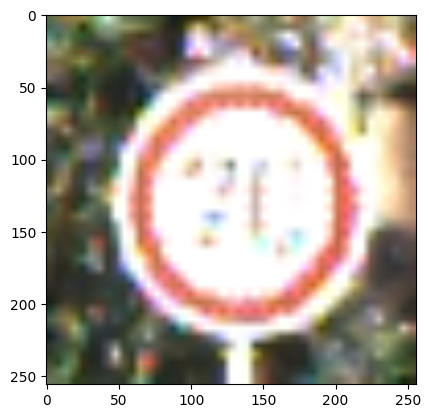

tensor(4)


In [68]:
# Visualize some images
images, label = next(iter(train_loader))

# Convert PyTorch tensor to a format compatible with matplotlib
image = images[0].permute(1, 2, 0)  # Rearrange dimensions from [Channel, Height, Width] to [H, W, C]

# Display the image
plt.imshow(image)
plt.show()

# Print the label for verification
print(label[0])

# Create CNN Model

In [69]:
# Evaluate function and accuracy calculation
def test(model, test_loader, device):
# Set model to evaluation mode
  model.eval()

  with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      predicted_output = model(images)
      _, predicted = torch.max(predicted_output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  acc = correct / total * 100
  return acc


In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class CNN(torch.nn.Module):
  def __init__(self, num_classes = num_classes):
    super(CNN, self).__init__()
    self.conv1 = torch.nn.Conv2d(3, 8, kernel_size = 5, stride = 1, padding = 2)
    self.batch1 = torch.nn.BatchNorm2d(8)
    self.relu1 = torch.nn.ReLU()
    self.drop1 = torch.nn.Dropout2d(p = 0.2)
    self.pool1 = torch.nn.MaxPool2d(kernel_size = 2)

    self.conv2 = torch.nn.Conv2d(8, 16, kernel_size = 5, stride = 1, padding = 2)
    self.batch2 = torch.nn.BatchNorm2d(16)
    self.relu2 = torch.nn.ReLU()
    self.drop2 = torch.nn.Dropout2d(p = 0.2)
    self.pool2 = torch.nn.MaxPool2d(kernel_size = 2)

    self.Flatten = torch.nn.Flatten()

    self.fc = torch.nn.Linear(16 * 64 * 64, out_features = num_classes)

  def forward(self, x):
    out = self.conv1(x)
    out = self.batch1(out)
    out = self.relu1(out)
    out = self.drop1(out)
    out = self.pool1(out)

    out = self.conv2(out)
    out = self.batch2(out)
    out = self.relu2(out)
    out = self.drop2(out)
    out = self.pool2(out)

    out = self.Flatten(out)

    out = self.fc(out)

    return torch.nn.functional.log_softmax(out, dim = 1)


model = CNN(num_classes).to(device)

print(summary(model, (3,256,256)))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 256, 256]             608
       BatchNorm2d-2          [-1, 8, 256, 256]              16
              ReLU-3          [-1, 8, 256, 256]               0
         Dropout2d-4          [-1, 8, 256, 256]               0
         MaxPool2d-5          [-1, 8, 128, 128]               0
            Conv2d-6         [-1, 16, 128, 128]           3,216
       BatchNorm2d-7         [-1, 16, 128, 128]              32
              ReLU-8         [-1, 16, 128, 128]               0
         Dropout2d-9         [-1, 16, 128, 128]               0
        MaxPool2d-10           [-1, 16, 64, 64]               0
          Flatten-11                [-1, 65536]               0
           Linear-12                   [-1, 43]       2,818,091
Total params: 2,821,963
Trainable params: 2,821,963
Non-trainable params: 0
---------------------------

In [71]:
# Loss and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [72]:
# Train the model

epoch_loss = 0
loss_list = []
training_loss = []
training_acc = []
epoch_num = []

model.train()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      # Set the model into training mode
      model.train()

      images = images.to(device)
      labels = torch.eye(num_classes)[labels].to(device)

      # forward pass
      outputs = model(images)
      loss = criterion(outputs, labels)

      # backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # calculate the loss
      epoch_loss = epoch_loss + loss.item()

      loss_list.append(epoch_loss)

      if (i+1) % 100 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()), flush=True)


    # training loss
    avg_loss = epoch_loss/ (i+1)
    training_loss.append(avg_loss)

    #accuracy
    accuracy = test(model, test_loader, device)
    training_acc.append(accuracy)

    epoch_num.append(epoch)
    epoch_loss = 0

Epoch [1/5], Step [100/2664], Loss 20.0401
Epoch [1/5], Step [200/2664], Loss 14.4144
Epoch [1/5], Step [300/2664], Loss 4.0017
Epoch [1/5], Step [400/2664], Loss 4.3031
Epoch [1/5], Step [500/2664], Loss 6.2155
Epoch [1/5], Step [600/2664], Loss 4.2696
Epoch [1/5], Step [700/2664], Loss 2.5859
Epoch [1/5], Step [800/2664], Loss 2.3344
Epoch [1/5], Step [900/2664], Loss 2.0304
Epoch [1/5], Step [1000/2664], Loss 1.1545
Epoch [1/5], Step [1100/2664], Loss 1.6951
Epoch [1/5], Step [1200/2664], Loss 1.2837
Epoch [1/5], Step [1300/2664], Loss 1.3850
Epoch [1/5], Step [1400/2664], Loss 1.2640
Epoch [1/5], Step [1500/2664], Loss 1.3658
Epoch [1/5], Step [1600/2664], Loss 0.5287
Epoch [1/5], Step [1700/2664], Loss 1.4778
Epoch [1/5], Step [1800/2664], Loss 1.2664
Epoch [1/5], Step [1900/2664], Loss 0.8237
Epoch [1/5], Step [2000/2664], Loss 0.9787
Epoch [1/5], Step [2100/2664], Loss 1.5808
Epoch [1/5], Step [2200/2664], Loss 0.7683
Epoch [1/5], Step [2300/2664], Loss 0.7303
Epoch [1/5], Step 

# Model Evaluation

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
tensor([[-64.1485, -53.9018, -45.6315, -44.8002, -66.5624, -30.7027, -61.9222,
         -25.4461, -49.7702, -35.1262, -40.7180, -51.5551, -71.7493, -75.1501,
         -65.7579, -75.1454,   0.0000, -54.5070, -57.8401, -50.1199, -48.3825,
         -52.8650, -98.7084, -43.2099, -63.5960, -67.8321, -69.1374, -45.2056,
         -63.8231, -53.0844, -58.7503, -59.5221, -68.9375, -70.5746, -54.9520,
         -69.1982, -53.1804, -53.5910, -71.3808, -61.7544, -53.5261, -40.4939,
         -48.4241]], grad_fn=<LogSoftmaxBackward0>)
AI predicted tensor([16]) with probability of tensor([0.], grad_fn=<MaxBackward0>)
Predicted:  tensor([16])
Label:  16


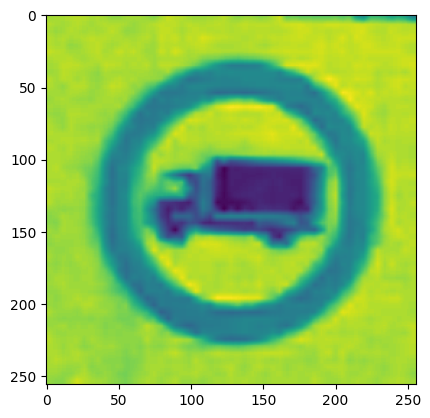

In [73]:
# Evaluate for 1 image only
img, label = test_dataset[0] # unpacking into image and label since the dataset consists of image and label

plt.imshow(img[0]) # 1 picture only
#print(label)

print(img.size()) # Size of 1 picture
print((img.unsqueeze(0)).size())

predicted_output = model(img.unsqueeze(0)) #
print(predicted_output) # the output is the probability
scores_probability, predicted = torch.max(predicted_output, 1) # scores_probability, predicted
print('AI predicted {} with probability of {}'.format(predicted, scores_probability))
print('Predicted: ', predicted)
print('Label: ', label)

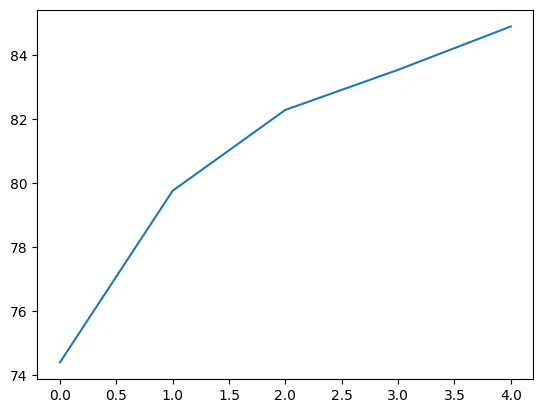

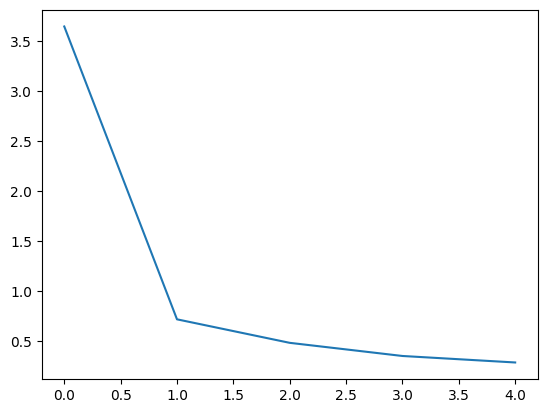

[[ 16  26   1 ...   0   0   0]
 [  0 664  31 ...   0   0   0]
 [  1  24 686 ...   0   0   0]
 ...
 [  0   0   0 ...  83   0   0]
 [  0   0   3 ...   0  43   1]
 [  0   0   0 ...   0   2  79]]
              precision    recall  f1-score   support

           0       0.94      0.27      0.42        60
           1       0.78      0.92      0.85       720
           2       0.80      0.91      0.85       750
           3       0.75      0.76      0.76       450
           4       0.97      0.75      0.84       660
           5       0.77      0.68      0.72       630
           6       0.77      0.69      0.73       150
           7       0.52      0.77      0.62       450
           8       0.71      0.79      0.75       450
           9       0.97      0.85      0.91       480
          10       0.81      0.97      0.88       660
          11       0.86      0.80      0.83       420
          12       0.96      0.98      0.97       690
          13       0.99      0.98      0.99       7

In [77]:
# Plot the graph training accuracy
plt.plot(epoch_num, training_acc)
plt.show()

#PLot the graph of training loss
plt.plot(epoch_num, training_loss)
plt.show()

# Classification report
y_pred = []
y_true = []

for images, labels in test_loader:
  predicted_output = model(images) # input into model becomes images

  _, predicted = torch.max(predicted_output, 1)
  y_pred.extend(predicted.data.cpu().numpy())

  labels = labels.data.cpu().numpy()
  y_true.extend(labels) # extend push to the back while append will stacking

cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
print(classification_report(y_true, y_pred))

In [76]:
# Save the model
torch.save(model.state_dict(), 'gtrsb_cnn2.pt')